In [1]:
# imports and setup
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data/all_years.csv', index_col=0)
len(df)

779223

In [3]:
# Group the columns into 1) raw input variables, 2) id variables of various things, 3) American Community Survey (census)
# variables, 4) NYC government-calculated variables, and 5) output variables.
#
# The ACS and NYC variables are generally calculated from the raw input variables - my initial expectation is that
# the raw input variables can be thought of as independent variables, and that the ACS and NYC variables are not
# independent even though they are not output variables.

raw_inp_vars = ['AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP','NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']

# Further group raw_inp_vars: a list of categories that will need to be bucketed for visualization, and those that won't
bucket_raw = ['AGEP', 'Off_Threshold', 'PreTaxIncome_PU', 'WKHP']
ok_raw = [var for var in raw_inp_vars if var not in bucket_raw]

id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']

acs_vars = ['AgeCateg', 'INTP_adj', 'OI_adj', 'MRGP_adj', 'PA_adj', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj']

nyc_vars = ['CitizenStatus',  'EducAttain', 'FTPTWork', 'FamType_PU', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_EITC', 'NYCgov_FICAtax', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', 'NYCgov_Nutrition', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_Threshold', 'NYCgov_WIC', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'TotalWorkHrs_PU']

output_vars = ['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']

all_columns = raw_inp_vars + id_vars + acs_vars + nyc_vars + output_vars

print('Number of columns in groups: ' + str(len(all_columns)))
print('Total columns in dataframe: ' + str(len(df.columns)))
# Double-check that all of the columns in the dataframe are assigned to one and only one group
print("Set of all dataframe columns that don't appear in a group: " + str(set(df.columns).difference(set(all_columns))))

Number of columns in groups: 80
Total columns in dataframe: 80
Set of all dataframe columns that don't appear in a group: set()


In [ ]:
sns.distplot(df.AGEP, bins=20, kde=False, rug=False)

In [ ]:
column = 'AGEP'
weight = 'PWGTP'
denominator = df[weight].sum()/len(df)
# create new column of weighted values
df['NewCol'] = (df[column] * df[weight])/ denominator
# create a Series of weighted values of interest (some weighted values are outliers)
counts = df.loc[df['NewCol'] < 100, 'NewCol']
counts.name = 'Weighted Ages'
sns.distplot(counts, bins=10, kde=False, rug=False)
# delete the weighted-value column - both to keep the data set manageable, and because we'll be reusing this code later
del(df['NewCol'])

In [ ]:
sns.distplot(df.Off_Threshold, bins=20, kde=False, rug=False)

In [ ]:
column = 'Off_Threshold'
weight = 'WGTP'
denominator = df[weight].sum()/len(df)
df['NewCol'] = (df[column] * df[weight])/ denominator
counts = df['NewCol']
counts.name = 'Weighted Off_Threshold'
sns.distplot(counts, bins=30, kde=False, rug=False)
del(df['NewCol'])

In [ ]:
sns.distplot(df.PreTaxIncome_PU, bins=20, kde=False, rug=False)

In [ ]:
column = 'PreTaxIncome_PU'
weight = 'WGTP'
denominator = df[weight].sum()/len(df)
df['NewCol'] = (df[column] * df[weight])/ denominator
counts = df['NewCol']
counts.name = 'Weighted PreTaxIncome_PU'
sns.distplot(counts, bins=30, kde=False, rug=False)
del(df['NewCol'])

In [ ]:
sns.distplot(df.WKHP, bins=20, kde=False, rug=False)

In [ ]:
column = 'WKHP'
weight = 'PWGTP'
denominator = df[weight].sum()/len(df)
df['NewCol'] = (df[column] * df[weight])/ denominator
counts = df['NewCol']
counts.name = 'Weighted WKHP'
sns.distplot(counts, bins=20, kde=False, rug=False)
del(df['NewCol'])

In [ ]:
# Create codes for the raw input variables that are number-coded, so we can create charts that make sense
raw_codes = {'Boro': {1: 'Bronx', 2: 'Brooklyn', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'},
         'CIT': {1: 'USA', 2: 'Territories', 3: 'US Parents', 4: 'Naturalized', 5: 'No'},
         'DIS': {1: 'Yes', 2: 'No'},
         'ENG': {0: '<5', 1: 'Very Well', 2: 'Well', 3: 'Not well', 4: 'Not at all', 5: 'Only Eng'},
         'ESR': {0: '<16', 1: 'EMP', 2:'EMP/NAW', 3: 'UNEMP', 4: 'AF', 5: 'AF/NAW', 6:'NILF'},
         'Ethnicity': {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'},
         'HHT': {0: 'NA', 1: 'MAR', 2: 'MNW', 3: 'WNM', 4: 'Malone', 5: 'MNAlone', 6: 'Walone', 7: 'WNalone'},
         'HIUnit_Head': {0: 'Not Head', 1: 'Head', 2: 'Not Head'},
         'HousingStatus': {1: 'Public', 2: 'Mitchell', 3: 'Subsidy', 4: 'Regulated', 5: 'OtherReg', 6: 'MarketRate', 7: 'NoCash', 8: 'OwnF&C', 9: 'Own-Mortgage'},
         'JWTR': {0: 'NA', 1: 'Car', 2: 'Bus', 3:'Streetcar', 4:'Subway', 5:'RR', 6:'Ferry', 7:'Taxi', 8:'Motorcycle', 9:'Bike', 10:'Walk', 11:'Home', 12: 'Other'},
         'LANX': {0: 'NA', 1: 'Yes', 2: 'Only Eng'},
         'MAR': {1: 'Married', 2:'Widowed', 3:'Divorced', 4:'Separated', 5:'Never Married'},
         'MSP': {0: 'NA', 1: 'Yes', 2:'Spouse absent', 3:'Widowed', 4:'Divorced', 5:'Separated', 6:'Never Married'},
         'NP': {},
         'REL': {0: 'Self', 1:'Spouse', 2:'Child', 3:'Adopted', 4:'Stepchild', 5:'Sibling', 6:'Parent', 7:'Grandchild', 8:'Parent-in-law', 9:'Child-in-law', 10:'Other', 11:'Boarder', 12:'Roommate', 13:'Partner', 14:'Foster', 15:'OtherNR', 16:'Inst', 17:'NonInst'},
         'SCH': {0: 'NA', 1: 'NoPast3Mos', 2:'Public', 3:'Private/Home'},
         'SCHG': {0: 'NA', 1:'Preschool', 2:'Kindergarten', 3:'1', 4:'2', 5:'3', 6:'4', 7:'5', 8:'6', 9:'7', 10:'8', 11:'9', 12:'10', 13:'11', 14:'12', 15:'College', 16:'Grad school'},
         'SCHL': {0: 'NA', 1:'None', 2:'Preschool', 3:'Kindergarten', 4:'1', 5:'2', 6:'3', 7:'4', 8:'5', 9:'6', 10:'7', 11:'8', 12:'9', 13:'10', 14:'11', 15:'12-NoDip', 16:'Diploma', 17:'GED', 18:'<1yrCollege', 19:'CollNoDegree', 20:'Associates', 21:'Bachelors', 22:'Masters', 23:'Professional', 24:'Doctorate'},
         'SEX': {1:'Male', 2:'Female'},
         'TEN': {0: 'NA', 1:'Mortage', 2:'Free&Clear', 3:'Rent', 4:'OccButNoRent'},
         'WKW': {0:'NA', 1:'50-52', 2:'48-49', 3:'40-47', 4:'27-39', 5:'14-26', 6:'<13'},
         'Year': {}
        }

In [ ]:
n = 0
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
column = 'Boro'
weight = 'PWGTP'
denominator = df[weight].sum()/len(df)
bronx = df.loc[df[column] == 1, weight].sum() / denominator
brooklyn = df.loc[df[column] == 2, weight].sum() / denominator
manhattan = df.loc[df[column] == 3, weight].sum() / denominator
queens = df.loc[df[column] == 4, weight].sum() / denominator
staten_island = df.loc[df[column] == 5, weight].sum() / denominator
all = pd.Series([bronx, brooklyn, manhattan, queens, staten_island], name='Boro')
plt = all.plot(kind='bar', title='Weighted Boro')
plt.set_xticklabels(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'])
pass

In [ ]:
n = 1
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 2
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 3
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
column = 'ENG'
weight = 'PWGTP'
denominator = df[weight].sum()/len(df)
u5 = df.loc[df[column] == 0, weight].sum() / denominator
vwell = df.loc[df[column] == 1, weight].sum() / denominator
well = df.loc[df[column] == 2, weight].sum() / denominator
notwell = df.loc[df[column] == 3, weight].sum() / denominator
notatall = df.loc[df[column] == 4, weight].sum() / denominator
only_eng = df.loc[df[column] == 5, weight].sum() / denominator
all = pd.Series([u5, vwell, well, notwell, notatall, only_eng], name='ENG')
plt = all.plot(kind='bar', title='Weighted ENG')
plt.set_xticklabels(['<5', 'Very Well', 'Well', 'Not well', 'Not at all', 'Only Eng'])
pass

In [ ]:
n = 4
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 5
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
column = 'Ethnicity'
weight = 'PWGTP'
denominator = df[weight].sum()/len(df)
white = df.loc[df[column] == 1, weight].sum() / denominator
black = df.loc[df[column] == 2, weight].sum() / denominator
asian = df.loc[df[column] == 3, weight].sum() / denominator
hispanic = df.loc[df[column] == 4, weight].sum() / denominator
other = df.loc[df[column] == 5, weight].sum() / denominator
labels = [v for v in raw_codes[column].values()]
all = pd.Series([white, black, asian, hispanic, other], name='Ethnicity')
plt = all.plot(kind='bar', title='Weighted Ethnicity')
plt.set_xticklabels(labels)
pass

In [ ]:
n = 6
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 7
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 8
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(y=counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
column = 'HousingStatus'
weight = 'WGTP'
denominator = df[weight].sum()/len(df)
public = df.loc[df[column] == 1, weight].sum() / denominator
mitchell = df.loc[df[column] == 2, weight].sum() / denominator
subsidy = df.loc[df[column] == 3, weight].sum() / denominator
regulated = df.loc[df[column] == 4, weight].sum() / denominator
other_reg = df.loc[df[column] == 5, weight].sum() / denominator
market_rate = df.loc[df[column] == 6, weight].sum() / denominator
no_cash = df.loc[df[column] == 7, weight].sum() / denominator
own = df.loc[df[column] == 8, weight].sum() / denominator
mortgage = df.loc[df[column] == 9, weight].sum() / denominator
labels = [v for v in raw_codes[column].values()]
all = pd.Series([public, mitchell, subsidy, regulated, other_reg, market_rate, no_cash, own, mortgage], name='HousingStatus')
plt = all.plot(kind='barh', title='Weighted HousingStatus')
plt.set_yticklabels(labels)
pass

In [ ]:
n = 9
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 10
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 11
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
column = 'MAR'
weight = 'WGTP'
denominator = df[weight].sum()/len(df)
married = df.loc[df[column] == 1, weight].sum() / denominator
widowed = df.loc[df[column] == 2, weight].sum() / denominator
divorced = df.loc[df[column] == 3, weight].sum() / denominator
separated = df.loc[df[column] == 4, weight].sum() / denominator
never_married = df.loc[df[column] == 5, weight].sum() / denominator
labels = [v for v in raw_codes[column].values()]
all = pd.Series([married, widowed, divorced, separated, never_married], name='MAR')
plt = all.plot(kind='bar', title='Weighted MAR')
plt.set_xticklabels(labels)
pass

In [ ]:
n = 12
group = ok_raw
if group[n] in raw_codes.keys():
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 13
group = ok_raw
if group[n] in raw_codes.keys() and raw_codes[group[n]] != {}:
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 14
group = ok_raw
if group[n] in raw_codes.keys() and raw_codes[group[n]] != {}:
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(y=counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 15
group = ok_raw
if group[n] in raw_codes.keys() and raw_codes[group[n]] != {}:
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 16
group = ok_raw
if group[n] in raw_codes.keys() and raw_codes[group[n]] != {}:
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(y=counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 17
group = ok_raw
if group[n] in raw_codes.keys() and raw_codes[group[n]] != {}:
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(y=counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 18
group = ok_raw
if group[n] in raw_codes.keys() and raw_codes[group[n]] != {}:
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 19
group = ok_raw
if group[n] in raw_codes.keys() and raw_codes[group[n]] != {}:
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 20
group = ok_raw
if group[n] in raw_codes.keys() and raw_codes[group[n]] != {}:
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 21
group = ok_raw
if group[n] in raw_codes.keys() and raw_codes[group[n]] != {}:
    counts = df[group[n]].copy()
    counts.replace(raw_codes[group[n]], inplace=True)
    sns.countplot(counts, order=raw_codes[group[n]].values())
else:
    sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 0
group = id_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 1
group = id_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 2
group = id_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 3
group = id_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 4
group = id_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 5
group = id_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 6
group = id_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 7
group = id_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 0
group = acs_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 1
group = acs_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 2
group = acs_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 3
group = acs_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 4
group = acs_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 5
group = acs_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 6
group = acs_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 7
group = acs_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 8
group = acs_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 9
group = acs_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [ ]:
n = 10
group = acs_vars
sns.distplot(df[group[n]], bins=12, kde=False, rug=False)

In [289]:
nyc_codes = {
    'CitizenStatus': {1: 'Birth', 2: 'Naturalized', 3: 'No'},
    'EducAttain': {0: 'NA', 1:'<HS', 2:'HS', 3:'SomeCollege', 4:'Bachelors+'},
    'FTPTWork': {1:'FTYR', 2:'<FTYR', 3:'None'},
    'FamType_PU': {1:'Family', 2:'Couple', 3:'M+kid', 4:'W+kid', 5:'Mnokid', 6:'Wnokid', 7:'Unrelated', 8:'UnrelAlone'},
    'NYCgov_REL': {0:'Self', 1:'Spouse', 2:'Child', 3:'Sibling', 4:'Parent', 5:'Grandkid', 6:'Inlaw', 7:'OtherRel', 8:'Boarder', 9:'Roommate', 10:'Partner', 11:'FosterKid', 12:'OtherNonRel'},
    'NYCgov_SFR': {0: 'NA', 1:'NoKids', 2:'Kids', 3:'OneParent', 4:'Kid', 5:'Kid-Monly', 6:'Kid-Wonly'},
    'Povunit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'SNAPUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'TaxUnit_FILER': {1:'Filer', 0:'Non-Filer'},
    'TaxUnit_FILESTAT': {1:'Joint', 2:'HH', 3:'MFS', 4:'Single'},
    'TaxUnit_FILETYPE': {1: 'Normal', 2:'Dependent', 3:'BelowThresh'},
    'TaxUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other', 5:'EIC', 6:'Relative'},
    'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'<1750', 5:'None'}
    }

In [ ]:
n = 0
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 1
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 2
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 3
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 4
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 5
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 6
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 7
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 8
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 9
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 10
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 11
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 12
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 13
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 14
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

In [ ]:
n = 15
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

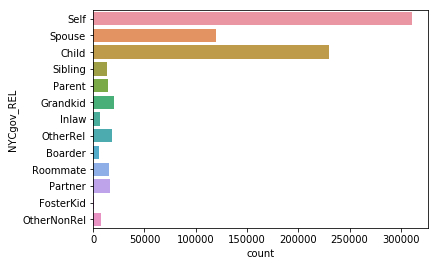

In [278]:
n = 16
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(y=counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

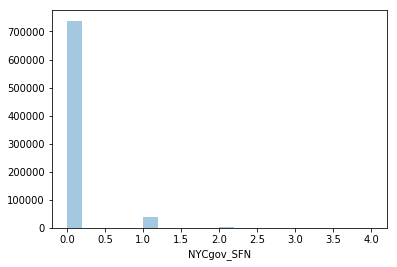

In [277]:
n = 17
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

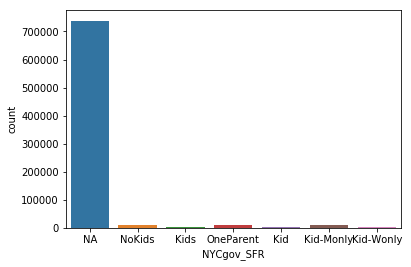

In [276]:
n = 18
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

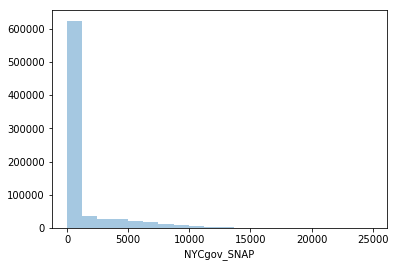

In [275]:
n = 19
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

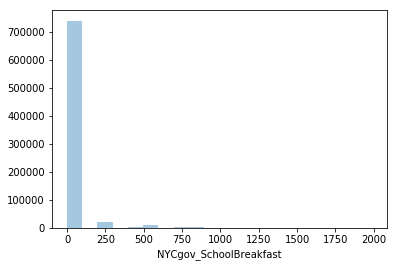

In [274]:
n = 20
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

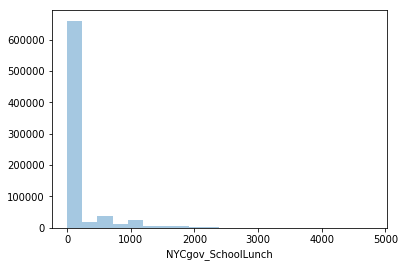

In [268]:
n = 21
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

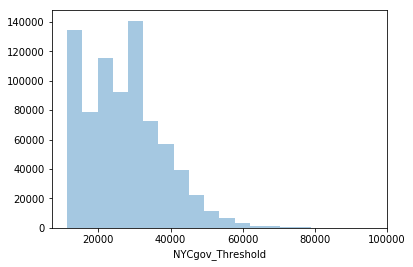

In [269]:
n = 22
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

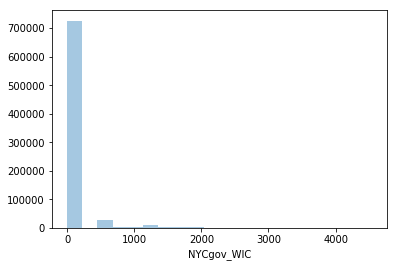

In [270]:
n = 23
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

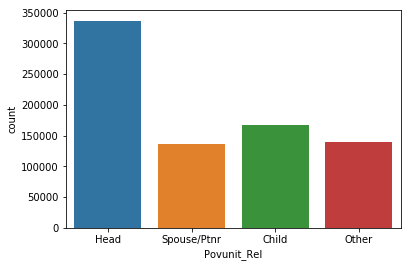

In [273]:
n = 24
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

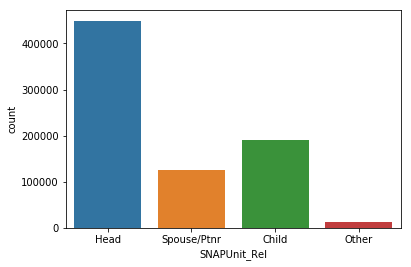

In [279]:
n = 25
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

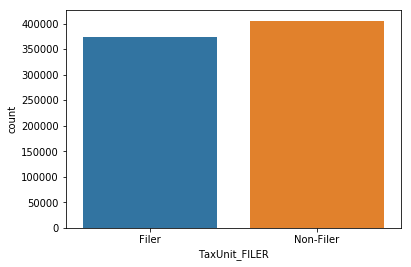

In [284]:
n = 26
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

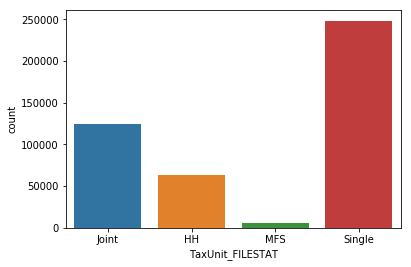

In [285]:
n = 27
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

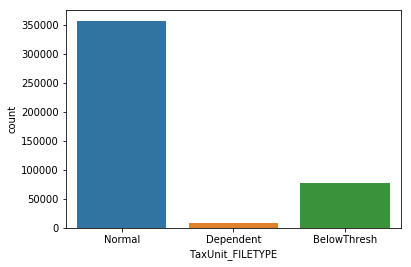

In [286]:
n = 28
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

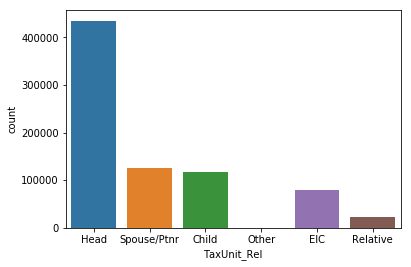

In [287]:
n = 29
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

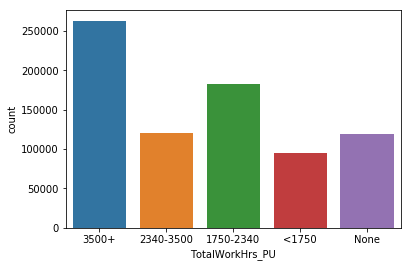

In [290]:
n = 30
labels = nyc_vars
dict = nyc_codes
if labels[n] in dict.keys() and dict[labels[n]] != {}:
    counts = df[labels[n]].copy()
    counts.replace(dict[labels[n]], inplace=True)
    sns.countplot(counts, order=dict[labels[n]].values())
else:
    sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

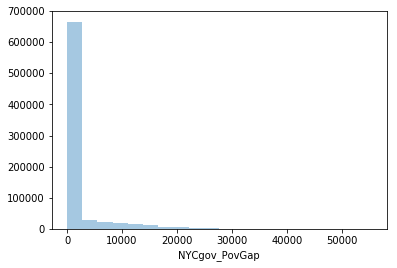

In [292]:
n = 0
labels = output_vars
sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

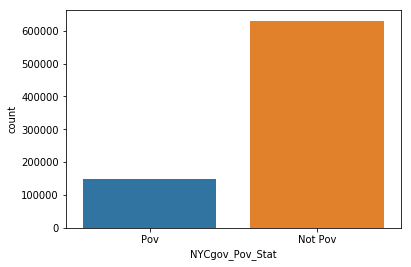

In [5]:
n = 1
labels = output_vars
counts = df[labels[n]].copy()
counts.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
sns.countplot(counts)

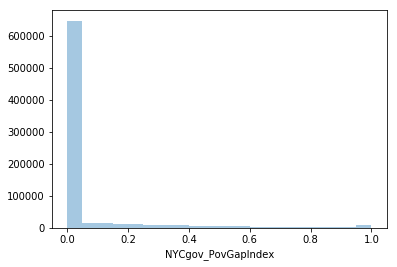

In [6]:
n = 2
labels = output_vars
sns.distplot(df[labels[n]], bins=20, kde=False, rug=False)

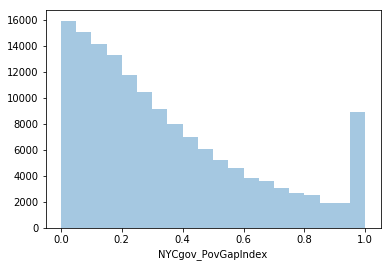

In [19]:
n = 2
labels = output_vars
counts = df.loc[df[labels[n]] > 0.0, labels[n]].copy()
sns.distplot(counts, bins=20, kde=False, rug=False)

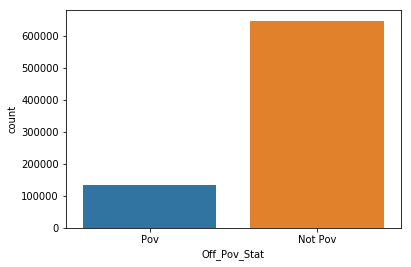

In [21]:
n = 3
labels = output_vars
counts = df[labels[n]].copy()
counts.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
sns.countplot(counts)

In [26]:
df['NYCgov_Pov_Stat'].value_counts() #19.13%
149066/(630157+149066)
df['Off_Pov_Stat'].value_counts() #17.02%
132636/(132636+646587)

0.1702157148852126

In [ ]:
def df_value_counts(df, column):
    '''Do value_counts on a single dataframe column, but don't order by the column.'''
    return pd.value_counts(df[column].values, sort=False)

def show_bucket_chart(df, column, bucket_list):
    '''Show a bucket chart for one column of a dataframe.
    Input: a dataframe, the name of a pre-bucketed column from that dataframe, and a list of labels for the buckets.
    Output: no return value.  Shows a bucket chart.'''

    counts = df_value_counts(df,column)
    print(counts)
    counts = counts.sort_index().set_axis(bucket_list, inplace=False)
    chart = counts.plot(kind='bar', title=column)
    chart.set_ylabel('Raw Pop')

In [ ]:
# Group the ages for visualization, and add a column to the dataframe to run them against.
age_group_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']
df['Age_bucket'] = df['AGEP'] // 10

show_bucket_chart(df, 'Age_bucket', age_group_labels)

In [ ]:
# Group the official poverty thresholds for visualization, and add a column to the dataframe to run them against.
threshold_group_labels = age_group_labels[:6]
df['Off_Threshold_bucket'] = df['Off_Threshold'] // 10000

show_bucket_chart(df, 'Off_Threshold_bucket', threshold_group_labels)

In [ ]:
# Group the pretax incomes for visualization, and add a column to the dataframe to run them against.
pretax_group_labels = age_group_labels + ['100+']
#pretax_group_labels = age_group_labels + ['100-119', '120-139', '140-159', '160-179', '180-199', '200+']
# Function to bucket the pretax groups into tens of thousands of dollars, or over 100k
def bucket_pretax(x):
    if x < 0:
        return 0
    else:
        return min(x//10000, 10)
    
df['PreTax_bucket'] = df['PreTaxIncome_PU'].apply(bucket_pretax)

show_bucket_chart(df, 'PreTax_bucket', pretax_group_labels)

In [ ]:
wkhp_group_labels = age_group_labels
df['WKHP_bucket'] = df['WKHP'] // 10

show_bucket_chart(df, 'WKHP_bucket', wkhp_group_labels)

In [ ]:
n = 0
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 1
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 2
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 3
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 4
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 5
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 6
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 7
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 8
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 9
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 10
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 11
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 12
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 13
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 14
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])

In [ ]:
n = 15
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])

In [ ]:
n = 16
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])

In [ ]:
n = 16
counts = df_value_counts(df.loc[df.SCHG > 0], ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])

In [ ]:
n = 17
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])

In [ ]:
n = 18
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])

In [ ]:
n = 19
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])

In [ ]:
n = 20
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])

In [ ]:
n = 21
counts = df_value_counts(df, ok_raw[n])
counts = counts.sort_index().rename(codes[ok_raw[n]])
print(df_value_counts(df, ok_raw[n]))
plt = counts.plot(kind='bar', title=ok_raw[n])
plt.set_ylabel('Raw Pop')

In [ ]:
n = 0
group = id_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 1
group = id_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 2
group = id_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 3
group = id_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 4
group = id_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 5
group = id_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 6
group = id_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 7
group = id_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 0
group = acs_vars
counts = df_value_counts(df, group[n]).sort_index().rename({1: '<18', 2: '18-64', 3: '65+'})
counts.plot(kind='bar', title=group[n])

In [ ]:
n = 1
group = acs_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)
#counts = df_value_counts(df, group[n])
#print(df_value_counts(df, group[n]))
#plt = sns.scatterplot(data=counts)
#plt.set_ylabel('Raw Pop')
#plt.set_title(group[n])

In [ ]:
n = 2
group = acs_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 3
group = acs_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 4
group = acs_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 5
group = acs_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 6
group = acs_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 7
group = acs_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 8
group = acs_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 9
group = acs_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 10
group = acs_vars
sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 0
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    plt = sns.scatterplot(data=counts)
    plt.set_title(group[n])
    plt.set_ylabel('Raw Pop')

In [ ]:
n = 1
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    plt = sns.scatterplot(data=counts)
    plt.set_title(group[n])
    plt.set_ylabel('Raw Pop')

In [ ]:
n = 2
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    plt = sns.scatterplot(data=counts)
    plt.set_title(group[n])
    plt.set_ylabel('Raw Pop')

In [ ]:
n = 3
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    plt = sns.scatterplot(data=counts)
    plt.set_title(group[n])
    plt.set_ylabel('Raw Pop')

In [ ]:
n = 4
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)
    #plt = sns.scatterplot(data=counts)
    #plt.set_title(group[n])
    #plt.set_ylabel('Raw Pop')

In [ ]:
n = 5
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 6
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 7
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 8
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 9
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 10
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 11
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 12
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 13
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 14
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 15
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 16
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 17
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 18
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
#tester3 = df[['SCHG']].copy()
#tester3.replace(codes['SCHG'], inplace=True)
#tester3 = tester3['SCHG']

tester3 = df['SCHG'].copy()
tester3.replace(codes['SCHG'], inplace=True)
#tester3 = tester3['SCHG']

#tester3 = tester3.value_counts(sort=False)
#tester3 = df_value_counts(df, 'SCHG')
#tester3 = pd.DataFrame(tester3)
#tester3.rename(index=codes['SCHG'], columns={0: 'SCHG'}, inplace=True)
#tester3 = tester3['SCHG']
#tester3.tail(30)
#list(codes['SCHG'].values())[1:]

#sns.catplot(tester3, kind='count')#, order=df.SCHG.index[:17])#, order=df.SCHG.iloc[:20].index)
#sns.countplot(tester3, order=codes['SCHG'].values())


sns.countplot(tester3, order=list(codes['SCHG'].values())[1:])
plt.xticks(rotation=90);

In [ ]:
n = 18
group = nyc_vars
counts = df_value_counts(df, group[n])
print(type(counts))
counts = counts.sort_index().rename(nyc_codes[group[n]])
print(counts.index)
sns.countplot(counts.T)#, order=counts.iloc[:50].index)
#sns.countplot(df[group[n]].)
    #counts), order=df[group[n]].iloc[:50].index)
counts

In [ ]:
n = 19
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 20
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 20
group = nyc_vars
counts = df_value_counts(df, group[n])
if group[n] in nyc_codes.keys():
    counts = counts.sort_index().rename(nyc_codes[group[n]])
    print(counts)
    plt = counts.plot(kind='bar', title=group[n])
    plt.set_ylabel('Raw Pop')
else:
    sns.distplot(df[group[n]], bins=10, kde=False, rug=False)

In [ ]:
n = 10
group = nyc_vars
counts = df_value_counts(df, group[n])
counts
plt = sns.scatterplot(data=df['NYCgov_Income'])

In [ ]:
nyc_vars[10]

In [ ]:
df.loc[df.PWGTP > 500, ['WGTP', 'PWGTP']].count()

In [ ]:
# Create a function to chart relationship between two variables
def show_indiv_charts(df, inp_column, out_column, description, inp_list, out_list):
    '''Show two single-variable charts of a particular dataframe by column.
    Input: a dataframe, an input column, an output column, a description of the output column, list of the input group
        names, and a list of the output group names. The "most-interesting" output should be the first element of the 
        list of output group names.
    Output: no return value. Shows two charts of percentages of output column, grouped by input column.'''
    
    # Focus on the columns of interest
    y = df[[inp_column, out_column]]
    
    # Count rows, grouping by input column and then output column
    group_counts = y.groupby([inp_column, out_column]).agg({out_column : 'count'})
    
    # Within each input group, count the percentage by output
    group_pcts = group_counts.groupby(inp_column).apply(lambda x: round(100 * x / float(x.sum()),1))
    
    # Reshape the dataframe so that each input group is one row, each output group is one column
    summary1 = pd.DataFrame(index=inp_list, columns=out_list, 
                            data=group_pcts.unstack().values.reshape(len(inp_list), len(out_list)))
    
    # Pull out the output column of interest to show a chart of just that by input group
    summary2 = summary1[out_list[0]].copy()
    
    # Plot and show the charts
    summary1.plot(kind='bar', stacked=True, title='Percentage ' + description + ' by ' + inp_column)
    plt.show()
    summary2.plot(kind='bar', title='Percent ' + description + ' by ' + inp_column)
    plt.show()
                                                                                                       
#show_indiv_charts(df=df, inp_column='Boro', out_column='NYCgov_Pov_Stat', description='Poverty', 
                  #inp_list=boroughs, out_list=['Poverty', 'Not in Poverty'])
                                                                                                       
df['AgeBucket'] = df['AGEP'] // 20

show_indiv_charts(df=df, inp_column='AgeBucket', out_column='NYCgov_Pov_Stat', description='Poverty', 
                  inp_list=['0-19','21-40','41-60','61-80','81-99'], out_list=['Poverty', 'Not in Poverty'])


In [ ]:
y = df[['Ethnicity', 'NYCgov_Pov_Stat']]
ethnicities = ['White', 'Black', 'Asian', 'Hisp', 'Other']
eth_counts = y.groupby(['Ethnicity','NYCgov_Pov_Stat']).agg({'NYCgov_Pov_Stat': 'count'})
eth_pcts = eth_counts.groupby('Ethnicity').apply(lambda x: round(100 * x / float(x.sum()),1))
summary1 = pd.DataFrame(index=ethnicities, columns=['Poverty', 'Not in Poverty'], data=eth_pcts.unstack().values.reshape(5,2))
summary2 = summary1['Poverty'].copy()
summary1.plot(kind='bar', stacked=True)
plt.show()
summary2.plot(kind='bar', title='Percent in Poverty by Ethnicity')
plt.show()

In [ ]:
df[output_vars].corr()

In [ ]:
import xlrd
test = pd.read_excel('data/NYCgov_Poverty_Measure_Data_Dictionary.xlsx', 'Column Info', skiprows=1, usecols=[0,2,3], names=list(range(3)))
d = test.set_index(0).to_dict(orient='index')